In [1]:
import toolviper
import xradio
import pathlib
import numba

import numpy as np
import pandas as pd
import calviper as cv

from xradio import measurement_set as ms

In [2]:
from IPython.display import display, HTML

display(HTML("<style>.container { width:200% !important; }</style>"))

In [3]:
if not pathlib.Path.cwd().joinpath("data/gaincaltest2.ps.zarr").exists():
    toolviper.utils.data.download("gaincal.test.zarr", "data")

In [4]:
df_gains = pd.read_csv("gains.csv")
gains = df_gains.gain.apply(complex).to_numpy()
gains

array([-0.63455564+0.47076233j,  1.15841049-0.81354628j,
        1.32849216+0.20964037j,  0.7710231 +0.13511301j,
        0.42394351-0.64036523j,  0.17546983-1.09119839j,
        0.41194325-0.57720941j, -0.00666993+0.52208018j,
        0.25330102-0.93767723j,  1.12460157+0.44485419j])

In [5]:
df_vis = pd.read_csv("vis.csv")
df_vis.drop(columns=["Unnamed: 0"], inplace=True)

vis = df_vis.vis.apply(complex).to_numpy()

ant_a = df_vis.ant_a.to_numpy()
ant_b = df_vis.ant_b.to_numpy()

In [6]:
from calviper.math.loss import mean_squared_error as mse

def build_vis(vis, index_a, index_b):
    count = 1
    
    X = np.zeros((10, 10), dtype=complex)

    for i in range(45):
        m = index_a[i]
        n = index_b[i]

        X[m, n] = X[m, n]*(count - 1) + vis[i]
        X[m, n] = X[m, n]/count

        X[n, m] = X[m, n].conj()

    return X

In [7]:
X = build_vis(vis, ant_a, ant_b)

In [8]:
solver = cv.math.solver.least_squares.LeastSquaresSolver()

In [9]:
g = solver.solve(
    vis=X,
    iterations=10,
    optimizer=cv.math.optimizer.MeanSquaredError(alpha=0.2),
    stopping=1e-2
)

[2024-12-18 12:42:19,374]     INFO    viperlog:  Iteration: (5)	Stopping criterion reached: 0.009207611105772 


In [10]:
ps = ms.open_processing_set("data/gaincaltest2.ps.zarr")

sub_ps = ps.sel(intents="CALIBRATE_DELAY#ON_SOURCE", scan_number=2)
sub_ps.summary()

,name,intents,shape,polarization,scan_number,spw_name,field_name,source_name,line_name,field_coords,start_frequency,end_frequency
1,gaincaltest2_0,"[CALIBRATE_DELAY#ON_SOURCE, CALIBRATE_PHASE#ON...","(957, 45, 8, 4)","[XX, XY, YX, YY]","[2, 4, 6, 9, 11, 14, 16, 18, 21, 23, 26]",X0000000000#ALMA_RB_03#BB_1#SW-01#FULL_RES_0,[J2255-3500_0],[J2255-3500_0],[],"[icrs, 22h55m57.68s, -35d00m00.00s]",8.607155e+10,8.629030e+10
0,gaincaltest2_2,"[CALIBRATE_DELAY#ON_SOURCE, CALIBRATE_PHASE#ON...","(957, 45, 8, 4)","[XX, XY, YX, YY]","[2, 4, 6, 9, 11, 14, 16, 18, 21, 23, 26]",X0000000000#ALMA_RB_03#BB_2#SW-01#FULL_RES_1,[J2255-3500_0],[J2255-3500_0],[],"[icrs, 22h55m57.68s, -35d00m00.00s]",8.794655e+10,8.816530e+10
3,gaincaltest2_4,"[CALIBRATE_DELAY#ON_SOURCE, CALIBRATE_PHASE#ON...","(957, 45, 8, 4)","[XX, XY, YX, YY]","[2, 4, 6, 9, 11, 14, 16, 18, 21, 23, 26]",X0000000000#ALMA_RB_03#BB_3#SW-01#FULL_RES_2,[J2255-3500_0],[J2255-3500_0],[],"[icrs, 22h55m57.68s, -35d00m00.00s]",9.632156e+10,9.654030e+10
2,gaincaltest2_6,"[CALIBRATE_DELAY#ON_SOURCE, CALIBRATE_PHASE#ON...","(957, 45, 8, 4)","[XX, XY, YX, YY]","[2, 4, 6, 9, 11, 14, 16, 18, 21, 23, 26]",X0000000000#ALMA_RB_03#BB_4#SW-01#FULL_RES_3,[J2255-3500_0],[J2255-3500_0],[],"[icrs, 22h55m57.68s, -35d00m00.00s]",9.819656e+10,9.841530e+10


In [11]:
sps = sub_ps["gaincaltest2_0"]

In [12]:
V = sps.VISIBILITY.mean(dim="time").data.compute()

In [13]:
def build_matrix(vis, index_a, index_b):
    length = index_a.shape[0]
    
    X = np.zeros((length, length), dtype=complex)
    
    for m in index_a:
        for n in index_b[1:]:
            X[m, n] = vis[m]
            X [n, m] = vis[m].conj()

    return X
            

def counter(n):
    counter = 0
    for i in range(n):
        for j in range(i, n):
            if i == j:
                continue
                
            counter += 1

    return counter

In [14]:
#@numba.njit()
def build_visibility_matrix(array: np.ndarray, index_a: np.ndarray, index_b: np.ndarray) -> np.ndarray:
    """
    Build a visibility matrix from a visibility array with zeros for autocorrelation.
    :param index_b:
    :param index_a:
    :param array: (numpy.ndarray) visibility array
    :return: (np.ndarray) Visibility matrix of dimension N x N.
    """
    # Get the full array length
    size = index_a.shape[0]

    # Calculate the N X N matrix size needed
    dimension = np.unique(index_a).shape[0] + 1

    # Build matrix
    matrix_ = np.zeros((dimension, dimension), dtype=np.complex64)

    for m in range(size):
        i = index_a[m]
        j = index_b[m]

        if i == j:
            continue
        print(f"({i}, {j}): {array[m]}")
        #matrix_[i, j] = array[m]
        #matrix_[j, i] = np.conj(array[m])

    return matrix_

In [15]:
vis_array = V[:, 0, 0]

index_a = cv.math.tools.encode(sps.baseline_antenna1_name.to_numpy())
index_b = cv.math.tools.encode(sps.baseline_antenna2_name.to_numpy())

V = cv.math.tools.build_visibility_matrix(array=vis_array, index_a=index_a, index_b=index_b)

In [19]:
g = solver.solve(
    vis=V,
    iterations=20,
    optimizer=cv.math.optimizer.MeanSquaredError(alpha=0.2),
    stopping=1e-3
)

[2024-12-18 12:44:37,826]     INFO    viperlog:  Iteration: (8)	Stopping criterion reached: 0.0006963677293142484 


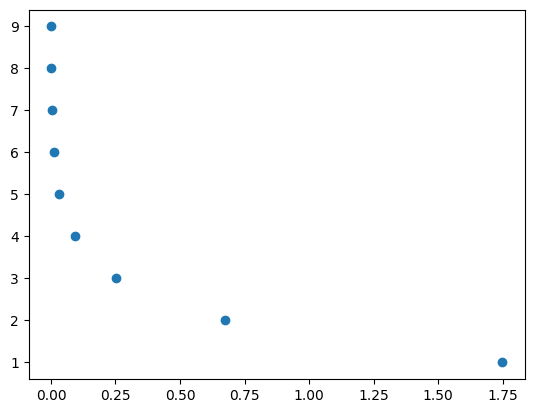

In [20]:
import matplotlib.pyplot as plt

t = np.linspace(1, len(solver.losses), len(solver.losses))

plt.scatter(solver.losses, t)

In [23]:
np.abs(solver.parameter)

array([1.00905625, 0.99933893, 0.97575698, 0.9569194 , 0.90247869,
       0.89927547, 0.89023273, 0.87823916, 0.89020347, 0.01342177])